In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn import preprocessing
import matplotlib.pyplot as plt
from w266_common import utils, vocabulary
from scipy import sparse
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

sess = tf.Session()

# Update with correct path for dataset 1
df = pd.read_csv('./Data/dataset1_shortjokes_uci.csv', encoding='latin-1')
X = df['text']
Y = df['funny']
shuffle = np.random.permutation(np.arange(df.shape[0]))

X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

test_data, test_label = X[round(X.shape[0]*.9):], Y[round(Y.shape[0]*.9):]
dev_data, dev_label = X[round(X.shape[0]*.7):round(X.shape[0]*.9)], Y[round(Y.shape[0]*.7):round(Y.shape[0]*.9)]
train_data, train_label = X[:round(X.shape[0]*.7)], Y[:round(Y.shape[0]*.7)]

print('test_data', test_data.shape)
print('dev_data', dev_data.shape)
print('train_data', train_data.shape)


/Users/geneahn/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


data shape:  (463314,)
label shape: (463314,)
test_data (46331,)
dev_data (92663,)
train_data (324320,)


In [3]:
train_label.head()

64964     1
201468    1
18902     1
344878    0
208436    1
Name: funny, dtype: int64

In [4]:
train_data.head()

64964     I lie in the bath for hours. But I try to tell...
201468    What's the difference between sex and a corpor...
18902     A husband and his wife. "honey I have a confes...
344878    The Big Bang Theory: Kaley Cuoco talks Johnny ...
208436    How do you catch a unique rabbit? You 'Neak Up...
Name: text, dtype: object

In [7]:
# EDA on string length
def word_count(string):
    tokens = string.split()
    n_tokens = len(tokens)
    return n_tokens 

wordcounts = train_data.apply(word_count)
max_doc_len = int(wordcounts.quantile(q=.99))
print(max_doc_len)

34


In [13]:
# Setup vocabulary processor
processor = preprocessing.VocabularyProcessor(max_doc_len)

processor.fit(train_data)
train = processor.transfocrm(train_data)
dev = processor.transform(dev_data)
test = processor.transform(test_data)

embedding_size = len(processor.vocabulary_)
print("unique vocab count:", embedding_size)

unique vocab count: 133229


In [14]:
train = np.array(list(train))
dev = np.array(list(dev))
test = np.array(list(test))

In [19]:
# Setup for Sklearn logistic regression
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(penalty ='l2', C=0.1)
logit.fit(train,train_label)
logit_pred = logit.predict(dev)
print("Accuracy w/ C=", 0.1, "is:{}".format(logit.score(dev,dev_label)))
print("F1 score w/ C =", 0.1, "is:{}".format(metrics.f1_score(dev_label,logit_pred,average='weighted')))
print("Sum of squared weights:", sum(logit.coef_**2))


Accuracy w/ C= 0.1 is:0.8159783300778088
F1 score w/ C = 0.1 is:0.8127855379740533
Sum of squared weights: [1.16535771e-09 1.69312497e-09 3.34710921e-10 1.34721727e-10
 1.89373961e-10 3.58203466e-11 2.50332491e-11 1.27405621e-12
 4.86822076e-12 1.36635432e-11 5.15175270e-11 1.66016022e-10
 4.76853051e-10 1.51329052e-09 5.59899846e-09 3.25373349e-08
 1.43147988e-07 1.59445582e-06 1.08000243e-06 4.79056799e-07
 3.31534669e-07 2.18165252e-06 1.48034444e-07 3.05805130e-08
 5.24965458e-09 3.53680510e-09 2.64233387e-09 2.30754644e-09
 2.83669940e-12 2.32059779e-10 1.51911249e-09 2.43068286e-07
 1.45634126e-08 5.40134027e-10]


In [ ]:
# Setup for Tensorflow logistic regression

In [210]:
df = pd.DataFrame({'x':dev_data.values, 'y': dev_label, 'y_hat':logit.predict(dev)})
df.to_csv('predictions.csv')

In [34]:
# Setup Index Matrix for one-hot-encoding
identity_mat = tf.diag(tf.ones(shape=[embedding_size]))

# Create variables for logistic regression
W = tf.Variable(tf.random_uniform(shape=[embedding_size,1]))
b = tf.Variable(tf.random_uniform(shape=[1,1]))

# Initialize placeholders
x_data = tf.placeholder(shape=[max_doc_len], dtype=tf.int32)
y_target = tf.placeholder(shape=[1, 1], dtype=tf.float32)

In [35]:
# Text-Vocab Embedding
x_embed = tf.nn.embedding_lookup(identity_mat, x_data)
x_col_sums = tf.reduce_sum(x_embed, 0)

# Declare model operations
x_col_sums_2D = tf.expand_dims(x_col_sums, 0)
model_output = tf.add(tf.matmul(x_col_sums_2D, W), b)

In [36]:
# Declare loss function (Cross Entropy loss)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

# Prediction operation
prediction = tf.sigmoid(model_output)

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

# Intitialize Variables
init = tf.global_variables_initializer()
sess.run(init)

In [ ]:
# Start Logistic Regression
print('Starting Training Over {} Sentences.'.format(len(train_data)))
loss_vec = []
train_acc_all = []
train_acc_avg = []
for ix, t in enumerate(train):
    y_data = [[train_label.iloc[ix]]]
    
    
    sess.run(train_step, feed_dict={x_data: t, y_target: y_data})
    temp_loss = sess.run(loss, feed_dict={x_data: t, y_target: y_data})
    loss_vec.append(temp_loss)
    
    if (ix+1)%10==0:
        print('Training Observation #' + str(ix+1) + ': Loss = ' + str(temp_loss))
        
    # Keep trailing average of past 50 observations accuracy
    # Get prediction of single observation
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
    # Get True/False if prediction is accurate
    train_acc_temp = train_label.iloc[ix]==np.round(temp_pred)
    train_acc_all.append(train_acc_temp)
    if len(train_acc_all) >= 50:
        train_acc_avg.append(np.mean(train_acc_all[-50:]))

Starting Training Over 277988 Sentences.


In [13]:
# Get test set accuracy
print('Getting Test Set Accuracy For {} Sentences.'.format(len(dev_data)))
test_acc_all = []
for ix, t in enumerate(dev):
    y_data = [[dev_label.iloc[ix]]]
    
    if (ix+1)%50==0:
        print('Test Observation #' + str(ix+1))    
    
    # Keep trailing average of past 50 observations accuracy
    # Get prediction of single observation
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
    # Get True/False if prediction is accurate
    test_acc_temp = dev_label.iloc[ix]==np.round(temp_pred)
    test_acc_all.append(test_acc_temp)

print('\nOverall Test Accuracy: {}'.format(np.mean(test_acc_all)))

Getting Test Set Accuracy For 46331 Sentences.
Test Observation #50
Test Observation #100
Test Observation #150
Test Observation #200
Test Observation #250
Test Observation #300
Test Observation #350
Test Observation #400
Test Observation #450
Test Observation #500
Test Observation #550
Test Observation #600
Test Observation #650
Test Observation #700
Test Observation #750
Test Observation #800
Test Observation #850
Test Observation #900
Test Observation #950
Test Observation #1000
Test Observation #1050
Test Observation #1100
Test Observation #1150
Test Observation #1200
Test Observation #1250
Test Observation #1300
Test Observation #1350
Test Observation #1400
Test Observation #1450
Test Observation #1500
Test Observation #1550
Test Observation #1600
Test Observation #1650
Test Observation #1700
Test Observation #1750
Test Observation #1800
Test Observation #1850
Test Observation #1900
Test Observation #1950
Test Observation #2000
Test Observation #2050
Test Observation #2100
Test Ob

Test Observation #17650
Test Observation #17700
Test Observation #17750
Test Observation #17800
Test Observation #17850
Test Observation #17900
Test Observation #17950
Test Observation #18000
Test Observation #18050
Test Observation #18100
Test Observation #18150
Test Observation #18200
Test Observation #18250
Test Observation #18300
Test Observation #18350
Test Observation #18400
Test Observation #18450
Test Observation #18500
Test Observation #18550
Test Observation #18600
Test Observation #18650
Test Observation #18700
Test Observation #18750
Test Observation #18800
Test Observation #18850
Test Observation #18900
Test Observation #18950
Test Observation #19000
Test Observation #19050
Test Observation #19100
Test Observation #19150
Test Observation #19200
Test Observation #19250
Test Observation #19300
Test Observation #19350
Test Observation #19400
Test Observation #19450
Test Observation #19500
Test Observation #19550
Test Observation #19600
Test Observation #19650
Test Observation

Test Observation #34950
Test Observation #35000
Test Observation #35050
Test Observation #35100
Test Observation #35150
Test Observation #35200
Test Observation #35250
Test Observation #35300
Test Observation #35350
Test Observation #35400
Test Observation #35450
Test Observation #35500
Test Observation #35550
Test Observation #35600
Test Observation #35650
Test Observation #35700
Test Observation #35750
Test Observation #35800
Test Observation #35850
Test Observation #35900
Test Observation #35950
Test Observation #36000
Test Observation #36050
Test Observation #36100
Test Observation #36150
Test Observation #36200
Test Observation #36250
Test Observation #36300
Test Observation #36350
Test Observation #36400
Test Observation #36450
Test Observation #36500
Test Observation #36550
Test Observation #36600
Test Observation #36650
Test Observation #36700
Test Observation #36750
Test Observation #36800
Test Observation #36850
Test Observation #36900
Test Observation #36950
Test Observation

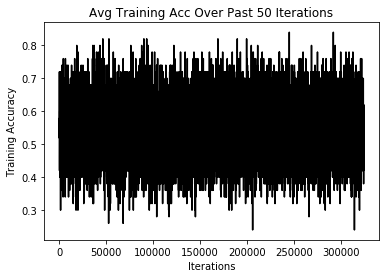

In [14]:
%matplotlib inline
# Plot training accuracy over time
plt.plot(range(len(train_acc_avg)), train_acc_avg, 'k-', label='Train Accuracy')
plt.title('Avg Training Acc Over Past 50 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Training Accuracy')
plt.show()